In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import seaborn as sns

# Load the data
log_file_path = "/home/aljazjustin/blockdoku_AI/blockdoku-AI/logs/training_log_20250510-1253.json"
try:
    with open(log_file_path, 'r') as f:
        data = json.load(f)
except FileNotFoundError:
    print(f"Error: Log file not found at {log_file_path}")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {log_file_path}")
    exit()

# Convert episodes list to DataFrame
if 'episodes' not in data or not isinstance(data['episodes'], list) or not data['episodes']:
    print(f"Error: 'episodes' key not found in JSON, is not a list, or is empty.")
    exit()
df = pd.DataFrame(data['episodes'])

if df.empty:
    print("Error: DataFrame is empty after loading episodes. Check log content.")
    exit()


In [135]:
import pprint

with open(log_file_path, 'r') as f:
    data = json.load(f)

    print("Training Settings:")
    print("=" * 40)
    
    # Pretty print the settings with formatting
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(data["settings"])
    
    # Additional summary info
    print("\nKey Hyperparameters:")
    print(f"Learning Rate: {data['settings'].get('learning_rate')}")
    print(f"Batch Size: {data['settings'].get('batch_size')}")
    print(f"Target Update Frequency: {data['settings'].get('target_update_freq')}")
    print(f"Gamma (Discount Factor): {data['settings'].get('gamma')}")


Training Settings:
{   'batch_size': 512,
    'epsilon_decay_steps': 75000,
    'epsilon_end': 0.05,
    'epsilon_start': 1.0,
    'gamma': 0.99,
    'invalid_move_penalty': -0.65,
    'learning_rate': 0.0005,
    'learning_starts': 50000,
    'num_episodes': 100000,
    'replay_buffer_size': 300000,
    'reward_block_placed': -0.1,
    'reward_line_square_clear': 2.0,
    'stuck_penalty_rl': -4.0,
    'target_update_freq': 100}

Key Hyperparameters:
Learning Rate: 0.0005
Batch Size: 512
Target Update Frequency: 100
Gamma (Discount Factor): 0.99


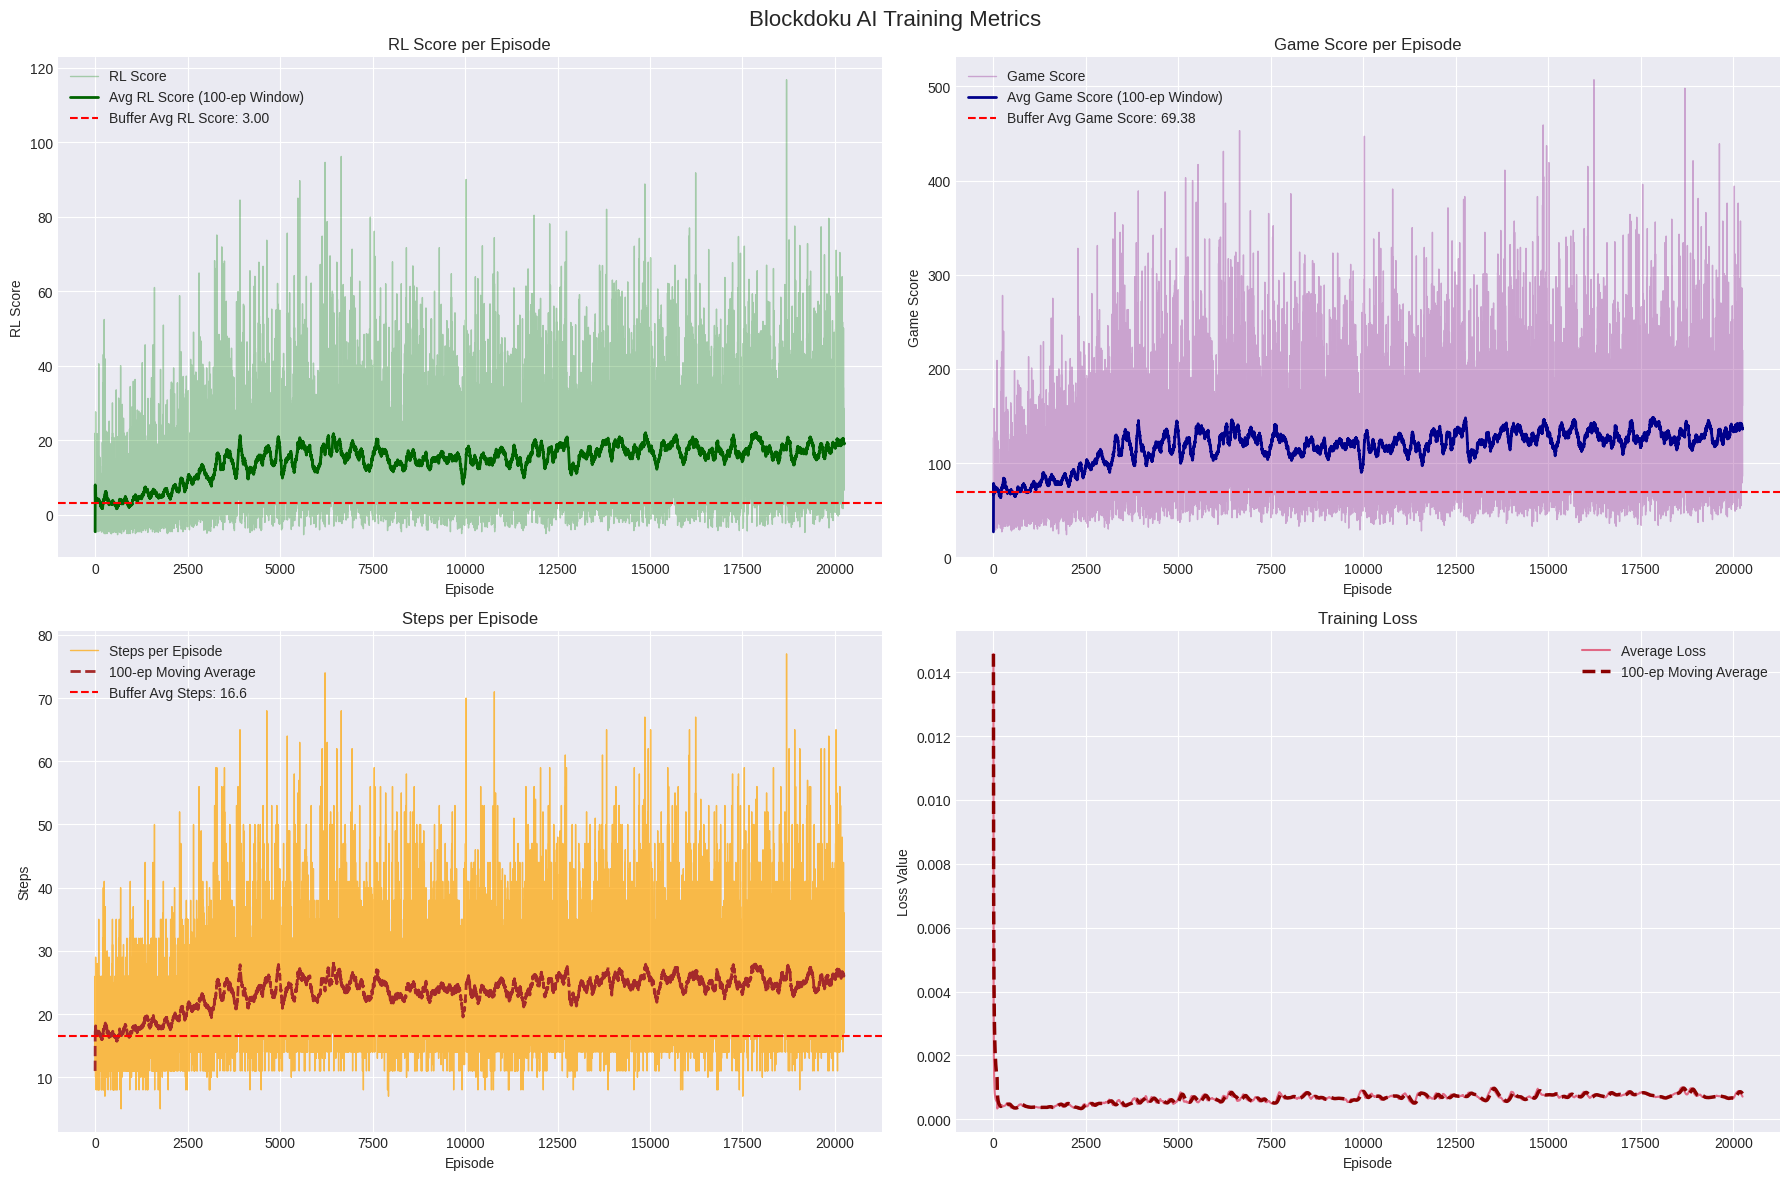

In [136]:
# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("viridis")

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Blockdoku AI Training Metrics', fontsize=16)

# 1. RL Score plot (top-left)
if 'episode' in df.columns and 'rl_score' in df.columns:
    # Raw scores with low alpha
    axes[0, 0].plot(df['episode'], df['rl_score'], color='green', linewidth=1, alpha=0.3, label='RL Score')
    
    # Pre-calculated average from the data file
    if 'avg_rl_score' in df.columns:
        axes[0, 0].plot(df['episode'], df['avg_rl_score'], 
                      color='darkgreen', linewidth=2,
                      label='Avg RL Score (100-ep Window)')
    
    # Add horizontal line for buffer average RL score
    buffer_avg_rl_score = 3.0
    axes[0, 0].axhline(y=buffer_avg_rl_score, color='red', linestyle='--', linewidth=1.5, 
                     label=f'Buffer Avg RL Score: {buffer_avg_rl_score:.2f}')
    
    axes[0, 0].set_title('RL Score per Episode')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('RL Score')
    axes[0, 0].legend()
else:
    axes[0, 0].set_title('RL Score Data Missing')
axes[0, 0].grid(True)

# 2. Game Score plot (top-right)
if 'episode' in df.columns and 'game_score' in df.columns:
    # Raw scores with low alpha
    axes[0, 1].plot(df['episode'], df['game_score'], color='purple', linewidth=1, alpha=0.3, label='Game Score')
    
    # Pre-calculated average from the data file
    if 'avg_game_score' in df.columns:
        axes[0, 1].plot(df['episode'], df['avg_game_score'], 
                      color='darkblue', linewidth=2,
                      label='Avg Game Score (100-ep Window)')
    
    # Add horizontal line for buffer average game score
    buffer_avg_game_score = 69.38
    axes[0, 1].axhline(y=buffer_avg_game_score, color='red', linestyle='--', linewidth=1.5, 
                     label=f'Buffer Avg Game Score: {buffer_avg_game_score:.2f}')
    
    axes[0, 1].set_title('Game Score per Episode')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Game Score')
    axes[0, 1].legend()
else:
    axes[0, 1].set_title('Game Score Data Missing')
axes[0, 1].grid(True)

# 3. Steps per Episode plot (bottom-left)
if 'episode' in df.columns and 'steps' in df.columns:
    axes[1, 0].plot(df['episode'], df['steps'], color='orange', linewidth=1, alpha=0.7, label='Steps per Episode')
    
    # Calculate moving average for steps
    window_size = 100
    if len(df['steps']) >= window_size:
        steps_ma = df['steps'].rolling(window=window_size, min_periods=1).mean()
        axes[1, 0].plot(df['episode'], steps_ma, 
                      color='brown', linewidth=2, linestyle='--',
                      label=f'{window_size}-ep Moving Average')
    
    # Add horizontal line for buffer average steps
    buffer_avg_steps = 16.6
    axes[1, 0].axhline(y=buffer_avg_steps, color='red', linestyle='--', linewidth=1.5, 
                     label=f'Buffer Avg Steps: {buffer_avg_steps:.1f}')
    
    axes[1, 0].set_title('Steps per Episode')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Steps')
    axes[1, 0].legend()
else:
    axes[1, 0].set_title('Steps Data Missing')
axes[1, 0].grid(True)

# 4. Loss plot (bottom-right) - using the pre-calculated avg_loss
if 'episode' in df.columns and 'avg_loss' in df.columns:
    axes[1, 1].plot(df['episode'], df['avg_loss'], color='crimson', linewidth=1.5, alpha=0.6, label='Average Loss')
    
    # Add moving average for smoothing
    window_size = 100
    if len(df['avg_loss']) >= window_size:
        loss_ma = df['avg_loss'].rolling(window=window_size, min_periods=1).mean()
        axes[1, 1].plot(df['episode'], loss_ma, 
                      color='darkred', linewidth=2.5, linestyle='--',
                      label=f'{window_size}-ep Moving Average')
    
    axes[1, 1].set_title('Training Loss')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Loss Value')
    axes[1, 1].legend()
else:
    axes[1, 1].set_title('Loss Data Missing')
axes[1, 1].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.94) 
plt.show()

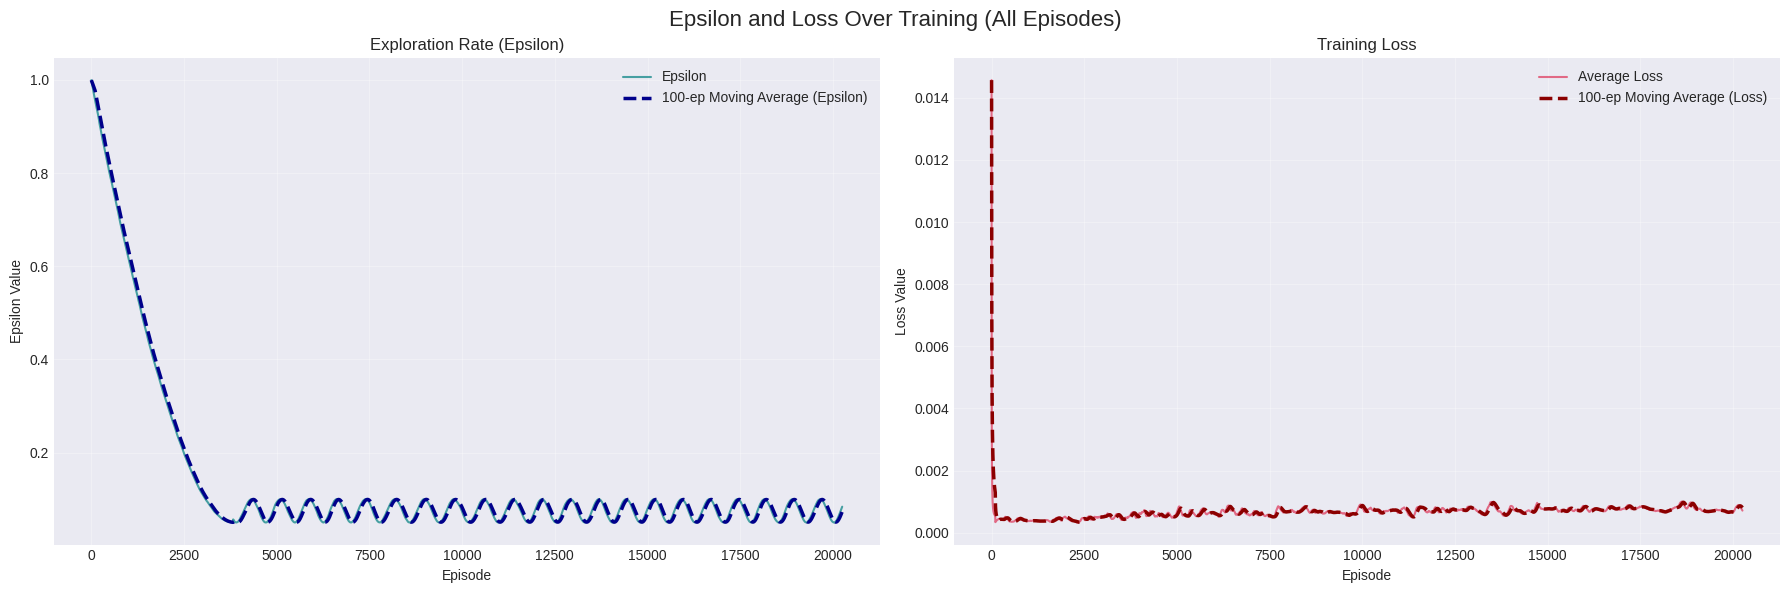

In [137]:

# Plot epsilon and loss values over training (all episodes)
fig_el, axes_el = plt.subplots(1, 2, figsize=(18, 6))
fig_el.suptitle('Epsilon and Loss Over Training (All Episodes)', fontsize=16)

# Epsilon plot
if 'episode' in df.columns and 'epsilon' in df.columns:
    axes_el[0].plot(df['episode'], df['epsilon'], color='teal', linewidth=1.5, alpha=0.7, label='Epsilon')
    if len(df['epsilon']) >= window_size:
        epsilon_ma = df['epsilon'].rolling(window=window_size, min_periods=1).mean()
        axes_el[0].plot(df['episode'], epsilon_ma, 
                 color='darkblue', linewidth=2.5, linestyle='--',
                 label=f'{window_size}-ep Moving Average (Epsilon)')
    axes_el[0].set_title('Exploration Rate (Epsilon)')
    axes_el[0].set_xlabel('Episode')
    axes_el[0].set_ylabel('Epsilon Value')
    axes_el[0].grid(True, alpha=0.3)
    axes_el[0].legend()
else:
    axes_el[0].set_title('Epsilon Data Missing')

# Loss plot
if 'episode' in df.columns and 'avg_loss' in df.columns:
    axes_el[1].plot(df['episode'], df['avg_loss'], color='crimson', linewidth=1.5, alpha=0.6, label='Average Loss')
    if len(df['avg_loss']) >= window_size:
        loss_ma = df['avg_loss'].rolling(window=window_size, min_periods=1).mean()
        axes_el[1].plot(df['episode'], loss_ma, 
                 color='darkred', linewidth=2.5, linestyle='--',
                 label=f'{window_size}-ep Moving Average (Loss)')
    axes_el[1].set_title('Training Loss')
    axes_el[1].set_xlabel('Episode')
    axes_el[1].set_ylabel('Loss Value')
    axes_el[1].grid(True, alpha=0.3)
    axes_el[1].legend()
else:
    axes_el[1].set_title('Loss Data Missing')

plt.tight_layout()
plt.subplots_adjust(top=0.90) 
plt.show()

Buffer Statistics:
Final buffer size: 300,000 experiences
Buffer growth rate: ~14.8 experiences per episode

Loss Statistics:
Final average loss: 0.00
Maximum loss: 0.01 (episode 1)
Minimum loss: 0.00 (episode 2293)


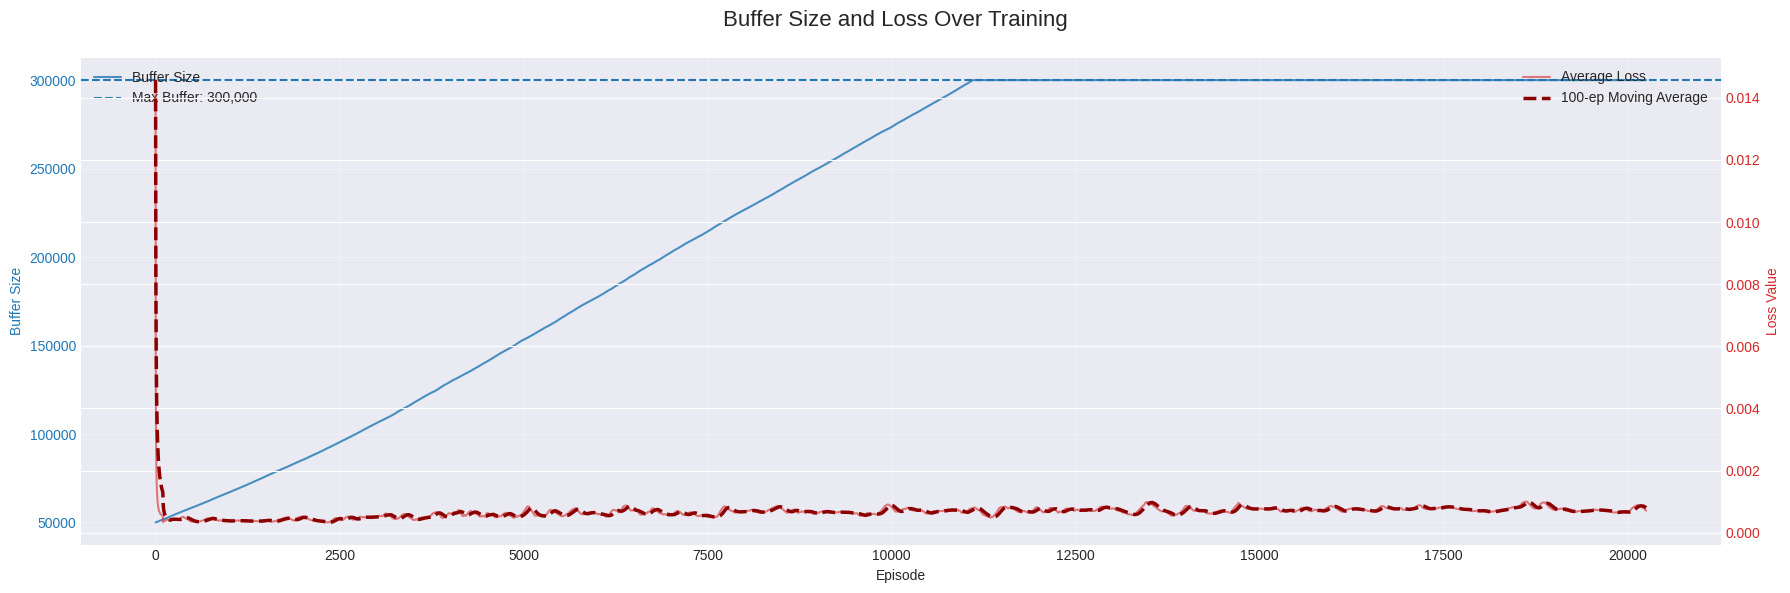

In [138]:
# Plot buffer size and loss values over training
fig_bl, ax1 = plt.subplots(figsize=(18, 6))
fig_bl.suptitle('Buffer Size and Loss Over Training', fontsize=16)

# Buffer size plot (left Y-axis)
if 'episode' in df.columns and 'buffer_size' in df.columns:
    color = 'tab:blue'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Buffer Size', color=color)
    ax1.plot(df['episode'], df['buffer_size'], color=color, linewidth=1.5, alpha=0.8, label='Buffer Size')
    
    # Add horizontal line for maximum buffer capacity if present in settings
    max_buffer_size = data['settings'].get('replay_buffer_size', 3000000)
    ax1.axhline(y=max_buffer_size, color=color, linestyle='--', linewidth=1.5, 
              label=f'Max Buffer: {max_buffer_size:,}')
    
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left')

# Loss plot (right Y-axis)
if 'avg_loss' in df.columns:
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Loss Value', color=color)
    ax2.plot(df['episode'], df['avg_loss'], color=color, linewidth=1.5, alpha=0.6, label='Average Loss')
    
    # Add moving average for smoothing
    window_size = 100
    if len(df['avg_loss']) >= window_size:
        loss_ma = df['avg_loss'].rolling(window=window_size, min_periods=1).mean()
        ax2.plot(df['episode'], loss_ma, 
                color='darkred', linewidth=2.5, linestyle='--',
                label=f'{window_size}-ep Moving Average')
    
    # Set reasonable y limits if loss explodes
    if df['avg_loss'].max() > 1000:
        # Find 99th percentile for setting a reasonable upper limit
        upper_limit = np.percentile(df['avg_loss'].dropna(), 99)
        ax2.set_ylim(0, upper_limit * 1.2)  # Add 20% margin
    
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')

# Print statistics
print(f"Buffer Statistics:")
print(f"Final buffer size: {df['buffer_size'].iloc[-1]:,} experiences")
print(f"Buffer growth rate: ~{df['buffer_size'].iloc[-1] / df['episode'].iloc[-1]:.1f} experiences per episode")

print(f"\nLoss Statistics:")
print(f"Final average loss: {df['avg_loss'].iloc[-1]:.2f}")
print(f"Maximum loss: {df['avg_loss'].max():.2f} (episode {df['episode'][df['avg_loss'].idxmax()]})")
print(f"Minimum loss: {df['avg_loss'].min():.2f} (episode {df['episode'][df['avg_loss'].idxmin()]})")

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [139]:
# # Create another figure to analyze the correlation between game score and steps
# # This will also use data from the learning phase onwards
# plt.figure(figsize=(10, 6))
# plot_data_for_correlation = df_learning if start_learning_episode > 1 and not learning_starts_df_empty and not df_learning.empty else df

# if not plot_data_for_correlation.empty and 'steps' in plot_data_for_correlation.columns and game_score_col in plot_data_for_correlation.columns:
#     plt.scatter(plot_data_for_correlation['steps'], plot_data_for_correlation[game_score_col], alpha=0.5)
#     title_suffix_corr = f'(From Ep {start_learning_episode})' if start_learning_episode > 1 and not learning_starts_df_empty and not df_learning.empty else '(All Episodes)'
#     plt.title(f'Relationship between Steps and Game Score {title_suffix_corr}')
    
#     valid_corr_data = plot_data_for_correlation[['steps', game_score_col]].dropna()
#     if len(valid_corr_data) > 1: 
#         z = np.polyfit(valid_corr_data['steps'], valid_corr_data[game_score_col], 1)
#         p = np.poly1d(z)
#         min_steps = valid_corr_data['steps'].min()
#         max_steps = valid_corr_data['steps'].max()
#         if min_steps is not np.nan and max_steps is not np.nan and min_steps < max_steps :
#              plt.plot(np.arange(min_steps, max_steps + 1), p(np.arange(min_steps, max_steps + 1)), "r--", linewidth=2, label='Trendline')
#         plt.legend()
# else:
#     plt.title('Steps vs Game Score Data Missing or Insufficient')

# plt.xlabel('Steps in Episode')
# plt.ylabel('Game Score')
# plt.grid(True)
# plt.show()

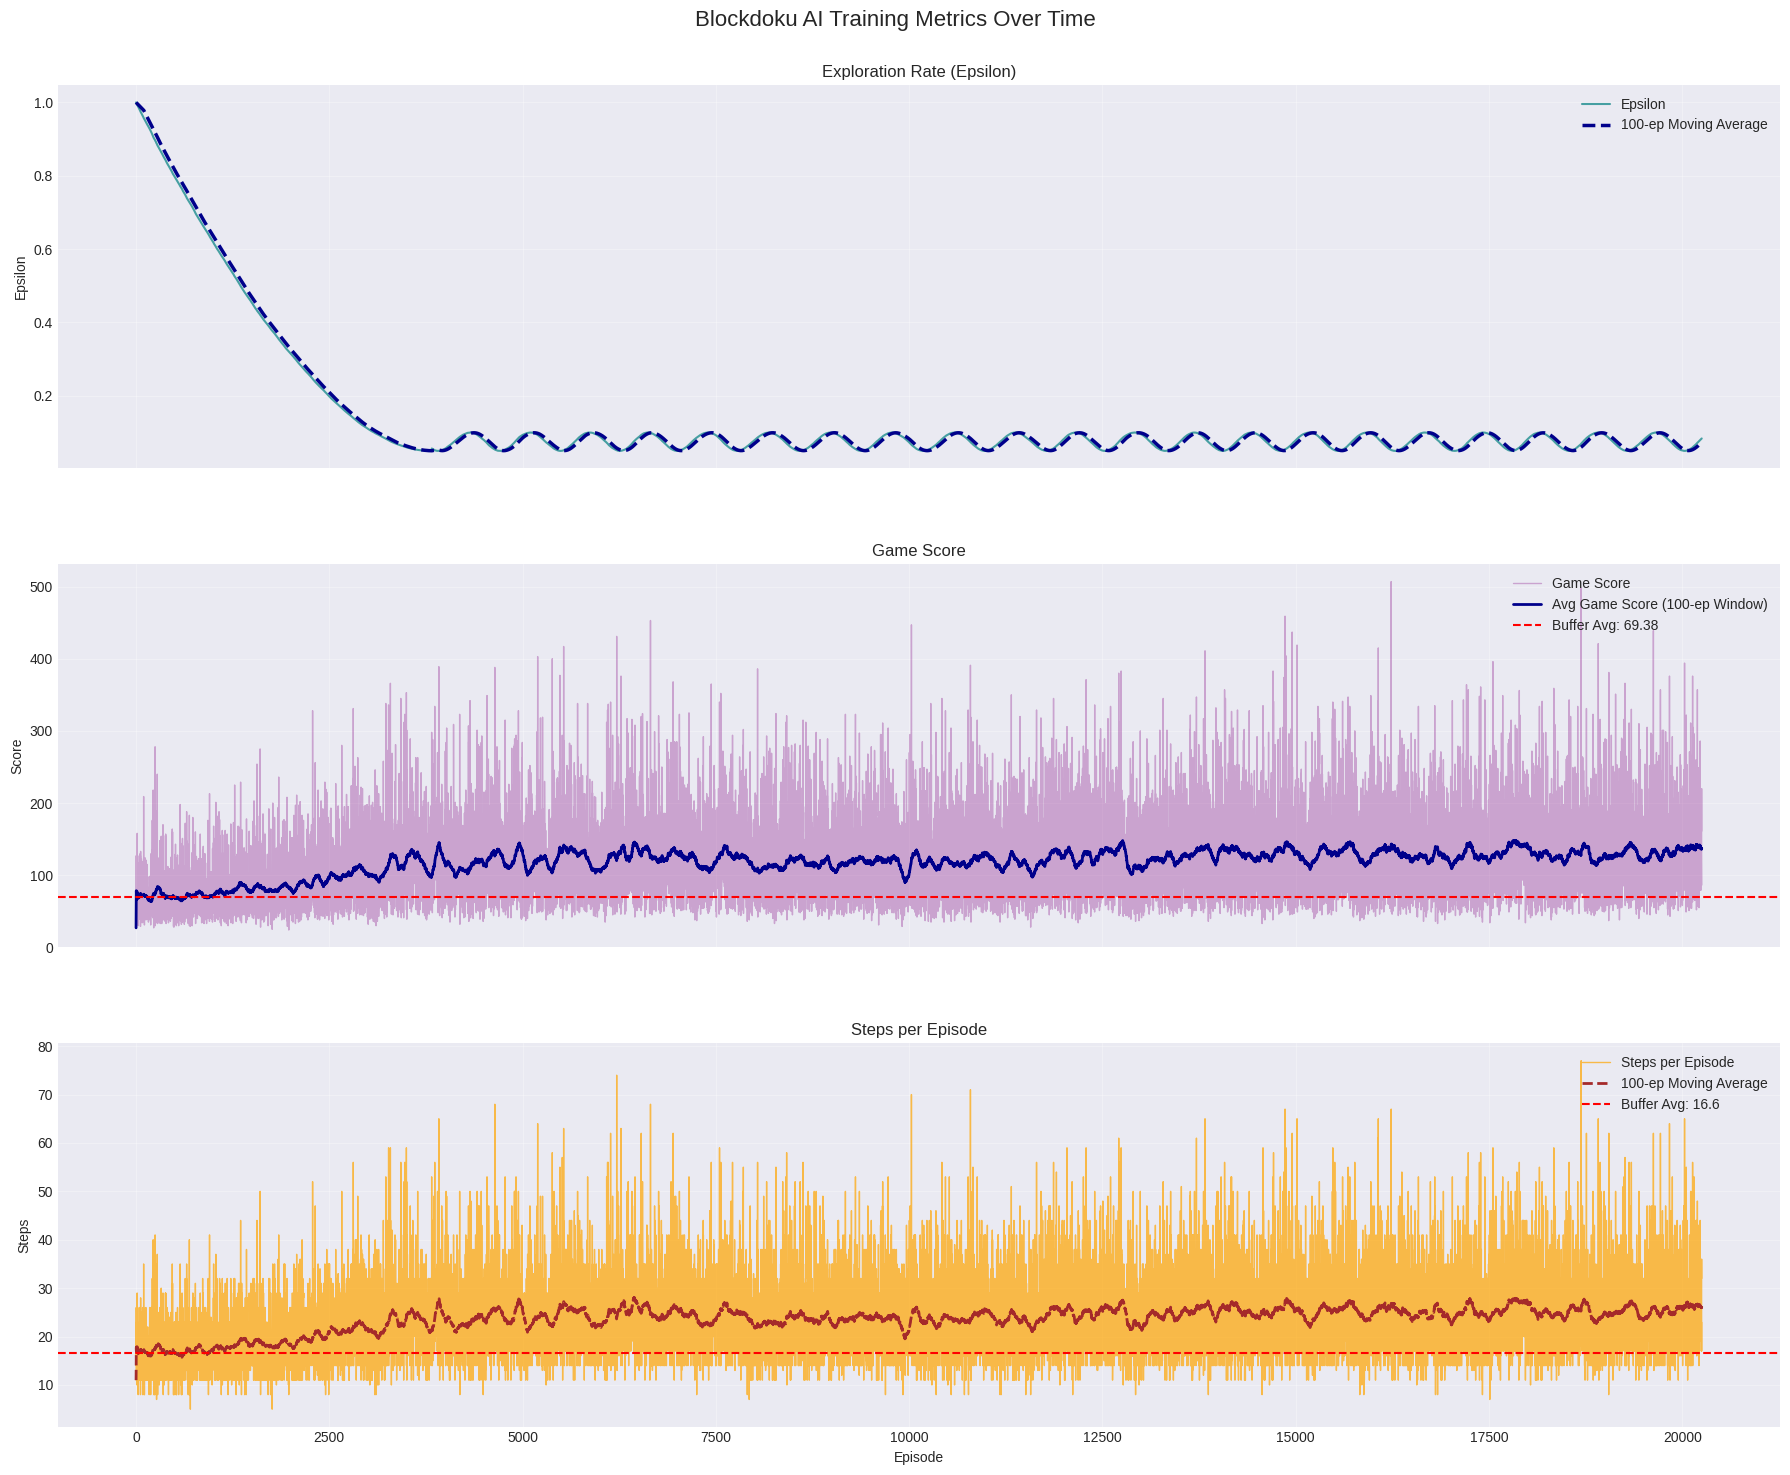

In [140]:
# Create stacked plots with shared x-axis
fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
fig.suptitle('Blockdoku AI Training Metrics Over Time', fontsize=16)
window_size = 100

# 1. Exploration Rate (Epsilon) - Top plot
if 'episode' in df.columns and 'epsilon' in df.columns:
    axes[0].plot(df['episode'], df['epsilon'], color='teal', linewidth=1.5, alpha=0.7, label='Epsilon')
    if len(df['epsilon']) >= window_size:
        epsilon_ma = df['epsilon'].rolling(window=window_size, min_periods=1).mean()
        axes[0].plot(df['episode'], epsilon_ma, 
                 color='darkblue', linewidth=2.5, linestyle='--',
                 label=f'{window_size}-ep Moving Average')
    axes[0].set_title('Exploration Rate (Epsilon)')
    axes[0].set_ylabel('Epsilon')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right')

# 2. Game Score - Middle plot
if 'episode' in df.columns and 'game_score' in df.columns:
    axes[1].plot(df['episode'], df['game_score'], color='purple', linewidth=1, alpha=0.3, label='Game Score')
    if 'avg_game_score' in df.columns:
        axes[1].plot(df['episode'], df['avg_game_score'], 
                   color='darkblue', linewidth=2,
                   label='Avg Game Score (100-ep Window)')
    # Add horizontal line for buffer average game score
    buffer_avg_game_score = 69.38
    axes[1].axhline(y=buffer_avg_game_score, color='red', linestyle='--', linewidth=1.5, 
                  label=f'Buffer Avg: {buffer_avg_game_score:.2f}')
    axes[1].set_title('Game Score')
    axes[1].set_ylabel('Score')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right')

# 3. Steps per Episode - Bottom plot
if 'episode' in df.columns and 'steps' in df.columns:
    axes[2].plot(df['episode'], df['steps'], color='orange', linewidth=1, alpha=0.7, label='Steps per Episode')
    if len(df['steps']) >= window_size:
        steps_ma = df['steps'].rolling(window=window_size, min_periods=1).mean()
        axes[2].plot(df['episode'], steps_ma, 
                   color='brown', linewidth=2, linestyle='--',
                   label=f'{window_size}-ep Moving Average')
    # Add horizontal line for buffer average steps
    buffer_avg_steps = 16.6
    axes[2].axhline(y=buffer_avg_steps, color='red', linestyle='--', linewidth=1.5, 
                  label=f'Buffer Avg: {buffer_avg_steps:.1f}')
    axes[2].set_title('Steps per Episode')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Steps')
    axes[2].grid(True, alpha=0.3)
    axes[2].legend(loc='upper right')

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.25)
plt.show()